### Handling null entries

In [15]:
import numpy as np
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('clean_df.csv')


In [49]:
import seaborn as sns

In [16]:
np.sum(df.isnull().any(axis=1))

2815

In [17]:
df.iloc[df[df.isnull().any(axis=1)].index,:].head()

,Unnamed: 0,text,target
208,208,NaN,0
249,249,NaN,0
398,398,NaN,0
430,430,NaN,0
1011,1011,NaN,0


Well, some unnecessary data must have been lost while cleaning like urls. 

Only 2815 empty records out of 1.6 billion..not that significant change so i am just gonna drop those records.

In [18]:
df.dropna(inplace=True)
df = df.iloc[: , 1:]
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597185 entries, 0 to 1597184
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1597185 non-null  object
 1   target  1597185 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


### Word Cloud( quick & dirty way of text analysis )

Let's see what words are more frequent

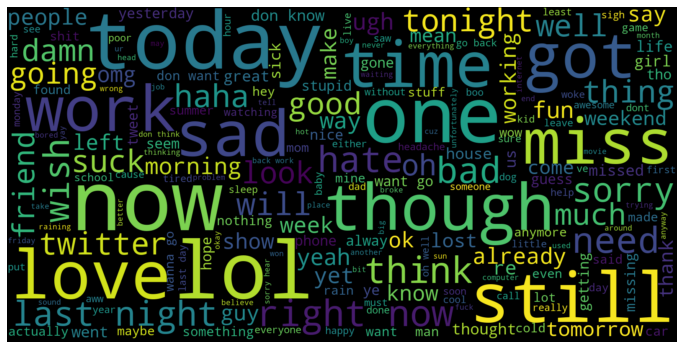

In [19]:
neg_tweets = df[df.target==0]
pos_tweets = df[df.target==4]
pos=list(pos_tweets.text)
pos = pd.Series(pos).str.cat(sep=' ')
neg=list(neg_tweets.text)
neg = pd.Series(neg).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Words like , "love", "today", "one",etc are more frequent words.I see some negative words like, "Sad", "hate", "miss", "ugh", and how can we forget "work"😂.

"Love"? what's it doing in negative tweets. Well i guess the context it's used in is negative or sarcastic. Let's check.

In [20]:
for i in neg_tweets.text[:150]:
    if 'love' in i:
        print(i)

ahh ive always wanted to see rent love the soundtrack !!
meh ... almost lover is the exception ... this track gets me depressed every time .
awe i love you too !!!! 1 am here i miss you
damn ! the grind is inspirational and saddening at the same time . don ' t want you to stop cuz i like what u do ! much love
i ' m missing you babe .. but as long as your alive i ' m happy .. ya i ' m tired my love imma try to sleep hopefully you had a headstart


Well there are mixed emotions and i think it's right that they classify as negative tweets

Let's have a look at Positive tweet wordcloud

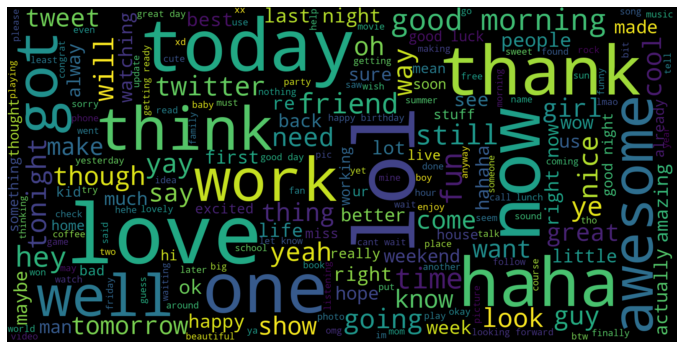

In [21]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Looks good! 
Again "Today" is more highlighted..

### Count vectorizer 
Calculates term frequency.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
cvec = CountVectorizer()
cvec.fit(df.text)

CountVectorizer()

In [24]:
len(cvec.get_feature_names())

285398

In [44]:
neg_doc_matrix = cvec.transform(df[df.target == 0].text)
pos_doc_matrix = cvec.transform(df[df.target == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()


you can directly get the term frequency from the sparse matrix. 

In [45]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313130,252526,565656
the,257797,265945,523742
my,190748,125935,316683
it,157165,147472,304637
and,153951,149620,303571
you,103790,198080,301870
is,128004,108913,236917
in,115433,101073,216506
for,98978,117357,216335
of,92716,91082,183798


So the term frequency dataframe is created!!

### Zipf's law

I studied Zipf's law recently, out of curiosity i want to see if this corpus follows the law.

It's an empirical law formulated using mathematical statistics that refers to the fact that for many types of data studied in the physical and social sciences, the rank-frequency distribution is an inverse relation. The Zipfian distribution is one of a family of related discrete power law probability distributions.

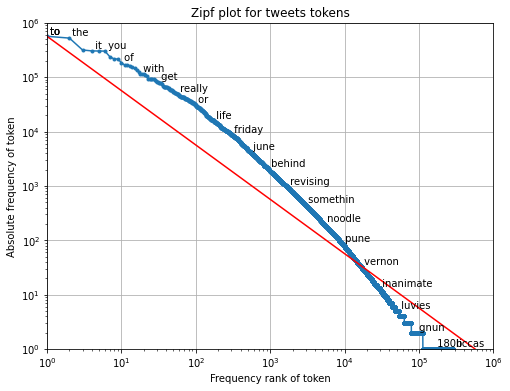

In [46]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Again we see a roughly linear curve, but deviating above the expected line on higher ranked words, and at the lower ranks we see the actual observation line lies below the expected linear line.

We could say it folllows a near Zipfian distribution

I wonder what's causing this deviation

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

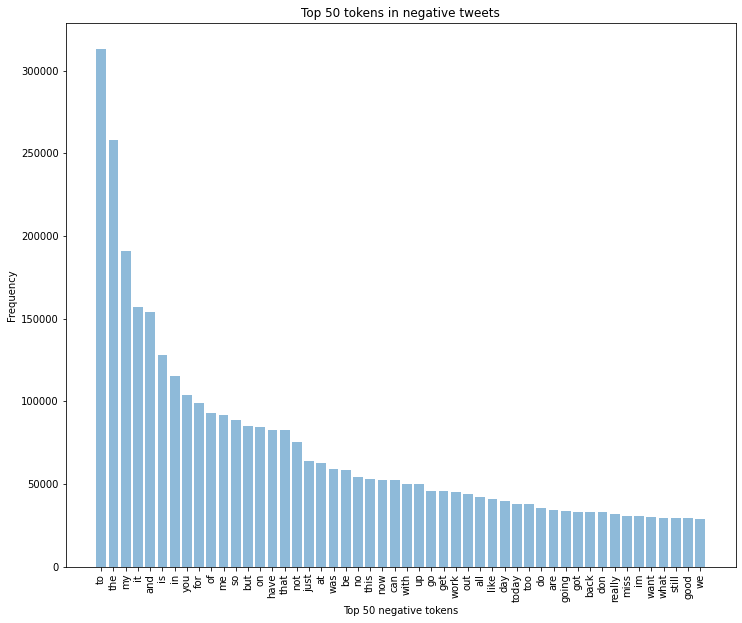

In [41]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

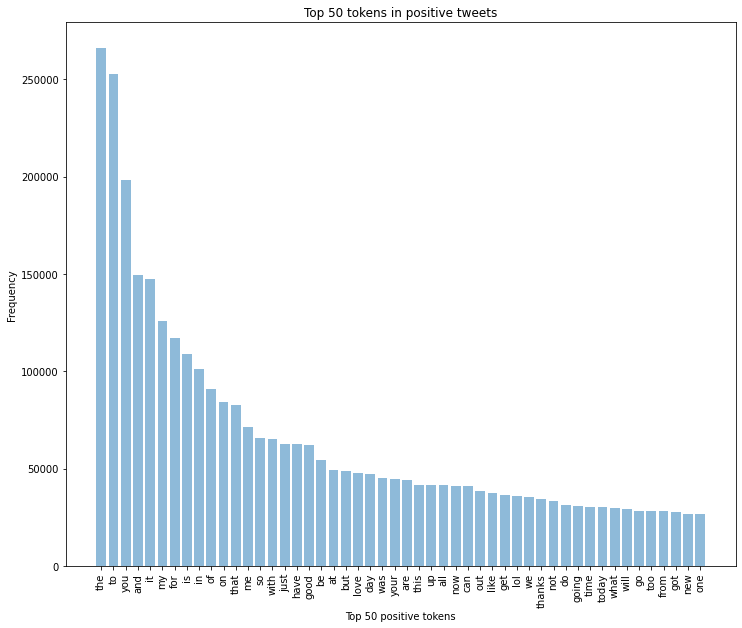

In [48]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

What are the important tokens in each class??
In order to find that im gonna check if there's any relation in positive and negative frequency or else i will need to create some metrics

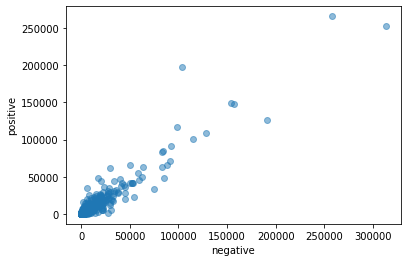

In [51]:
ax = sns.regplot(x='negative', y='positive',fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)


Meh. 
Let’s explore what we can get out of frequency of each token. Intuitively, if a word appears more often in one class compared to another, this can be a good measure of how much the word is meaningful to characterise the class

In [62]:
term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[61:70]

,negative,positive,total,pos_rate
giantbomb,0,1,1,1.0
gianormous,0,1,1,1.0
saulinha,0,1,1,1.0
saute,0,1,1,1.0
ghouse,0,1,1,1.0
sauted,0,1,1,1.0
sautee,0,1,1,1.0
savekitt,0,2,2,1.0
ghni,0,2,2,1.0
